In [390]:

# Google earth engine
import ee
# Authenticate and initialize Earth Engine API
#ee.Authenticate()  # Only required once
ee.Initialize(
      opt_url='https://earthengine-highvolume.googleapis.com'
)

# Built-in modules
import os
import subprocess
from pathlib import Path
import datetime
from datetime import date
from urllib.request import urlopen
from typing import Any, Optional, Tuple

# Basics of Python data handling and visualization
import math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Geospatial
import geemap
import geopandas as gpd
from shapely import wkt
from shapely.geometry import (
    shape,
    Point,
    LineString,
    Polygon,
    MultiPoint,
    MultiLineString,
    MultiPolygon
)
from shapely.validation import make_valid
import geojson
import folium
from geopy.distance import great_circle
from gadm import GADMDownloader
import rasterio
from rasterio import plot
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`


# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import (
    plot_image, 
    plot_image_with_vectors,
    get_country_boundary_fromGADM, 
    get_adminl1_names_fromGADM, 
    get_adminl2_names_fromGADM,
    find_admin_names_fromGADM,
    get_admin_l2_fromGADM, 
    get_alladmin_fromGADM, 
    split_bbox_into_blocks, 
    generate_sampling_grid, 
    get_s2_sr_cld_col, 
    add_cloud_bands, 
    add_shadow_bands, 
    add_cld_shdw_mask,
    add_cld_mask, 
    apply_cld_shdw_mask, 
    get_cloudless_image, 
    get_cloudless_collection,
    get_landcover, 
    get_landcover_mosaic,
    get_viirs_composite, 
    get_ee_feature, 
    get_built_areas, 
    get_adjacent_blocks, 
    get_new_adjacent_blocks,
    plot_block_and_adjacent
)

In [391]:
# Other 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [435]:
# GLOBAL PARAMS:

# Country: Select one of: ["Brazil", "India", "Indonesia", "Ethiopia", "Nigeria"]
COUNTRY = "Nigeria"

# FILE PATHS (GLOBALS)
cdir = os.getcwd()
pdir = os.path.dirname(cdir)
DOWNLOADS_FOLDER = os.path.join(pdir, "downloads", COUNTRY)
OUTPUTS_FOLDER = os.path.join(pdir, "outputs", COUNTRY)

# Create folders if they don't exist
os.makedirs(DOWNLOADS_FOLDER, exist_ok=True)
os.makedirs(OUTPUTS_FOLDER, exist_ok=True)

# Size of the blocks for the sampling grid
BLOCK_SIZE = 150
STAGE_1_SAMPLE_SIZE = 125

# Level 1 and 2 administrative unit types: 
if (COUNTRY == "Nigeria"):
    L1_UNIT = "State"
    L2_UNIT = "Local government area(s)"

if (COUNTRY == "Ethiopia"):
    L1_UNIT = "Region"
    L2_UNIT = "Chartered city"

if (COUNTRY == "Brazil"):
    L1_UNIT = "State"
    L2_UNIT = "Municipality"

if (COUNTRY == "Indonesia"):
    L1_UNIT = "Province"
    L2_UNIT = "Municipality"

if (COUNTRY == "India"):
    L1_UNIT = "State"
    L2_UNIT = "District"

In [436]:
# STEP 1: DEFINING AREA OF INTEREST
# CREATE CUSTOM POLYGON USING GADM LEVEL 2 BOUNDARIES

if (COUNTRY == "Nigeria"):
    # Only the LGA's in Lagos division will be included
    ADM_L1 = "Lagos"
    ADM_L2 = ["Lagos Mainland", "Lagos Island", "Eti-Osa", "Apapa", "Surulere"]
    # Load the .geojson file
    # Source of geojson for Nigeria: UN HDX (Humanitarian data exchange)
    geojson_file = os.path.join(DOWNLOADS_FOLDER, 'ADM_L2_UN/nigeria_adm_l2_un.geojson')
    ADMIN = gpd.read_file(geojson_file)
    COUNTRY_POLY = gpd.GeoDataFrame(geometry = [ADMIN.unary_union], crs='epsg:4326')
    COUNTRY_L1_POLY = get_alladmin_fromGADM(COUNTRY, admin_level = 1)
    # Rename admin2Name_en to NAME_2
    ADMIN = ADMIN.rename(columns={'admin2Name_en': 'NAME_2'})
    # Rename adm1Name_en to NAME_1
    ADMIN = ADMIN.rename(columns={'admin1Name_en': 'NAME_1'})
    COUNTRY_L2_POLY = ADMIN
    # Display unique values in NAME_1
    print("Level 1 names: ", ADMIN['NAME_1'].unique())
    # Subset L1_ADMINS to only include "Lagos" in NAME_1
    ADMIN = ADMIN[ADMIN['NAME_1'] == ADM_L1]
    # Display unique values in NAME_2 
    print("Level 2 names:", ADMIN['NAME_2'].unique())
    # Subset L2_ADMINS to only include ADM_L2 sub-units
    ADMIN = ADMIN[ADMIN['NAME_2'].isin(ADM_L2)]
    PERIM = gpd.GeoDataFrame(geometry=[ADMIN.unary_union], crs='epsg:4326')

if (COUNTRY == "India"): 
    ADM_L1 = "Delhi"
    ADM_L2 = ["New Delhi", "South West", "West", "North West", "North", "North East", "East", "Central", "South", "South East", "Shahdara"]
    # Delhi encompasses 11 districts which will all be included
    # Source of geojson for India: UN HDX (Humanitarian data exchange)
    geojson_file = os.path.join(DOWNLOADS_FOLDER, 'ADM_L1_UN/geoBoundaries-IND-ADM1.geojson')
    COUNTRY_L1_POLY = gpd.read_file(geojson_file)
    COUNTRY_L1_POLY = COUNTRY_L1_POLY.rename(columns={'shapeName': 'NAME_1'})
    COUNTRY_POLY = gpd.GeoDataFrame(geometry = [COUNTRY_L1_POLY.unary_union], crs='epsg:4326')

    geojson_file = os.path.join(DOWNLOADS_FOLDER, 'ADM_L1_UN/geoBoundaries-IND-ADM2.geojson')
    COUNTRY_L2_POLY = gpd.read_file(geojson_file)
    COUNTRY_L2_POLY = COUNTRY_L2_POLY.rename(columns={'shapeName': 'NAME_2'})
    # Remove trailing and leading white space from NAME_2
    COUNTRY_L2_POLY['NAME_2'] = COUNTRY_L2_POLY['NAME_2'].str.strip()

    ADMIN = COUNTRY_L2_POLY[COUNTRY_L2_POLY['NAME_2'].isin(ADM_L2)]
    PERIM = gpd.GeoDataFrame(geometry=[ADMIN.unary_union], crs='epsg:4326')
    

if (COUNTRY not in ["Nigeria", "India"]):

    # Explore and select administrative boundaries available from GADM
    admin_names = find_admin_names_fromGADM(COUNTRY)
    ADM_L1 = admin_names[0]
    ADM_L2 = admin_names[1]

    if (COUNTRY == "Indonesia"):
        ADM_L2 = ['Jakarta Barat', 'Jakarta Pusat', 'Jakarta Selatan', 'Jakarta Timur', 'Jakarta Utara']

    COUNTRY_POLY = get_country_boundary_fromGADM(COUNTRY)
    COUNTRY_L1_POLY = get_alladmin_fromGADM(COUNTRY, admin_level = 1)
    COUNTRY_L2_POLY = get_alladmin_fromGADM(COUNTRY, admin_level = 2)
    ADMIN = get_admin_l2_fromGADM(COUNTRY, ADM_L1, ADM_L2, join = False)
    ADMIN = ADMIN.to_crs('epsg:4326')
    PERIM = get_admin_l2_fromGADM(COUNTRY, ADM_L1, ADM_L2, join = True)
    PERIM = PERIM.to_crs('epsg:4326')

BUFFER = 0.01

PERIM_EE = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in PERIM.iterrows()])
# Return the bounding box that encloses the perimeter boundary polygon
BBOX = PERIM.bounds
# Add buffer to bouding box
BBOX_BUFF = PERIM.buffer(BUFFER).bounds
# Returns the enveleope of the admin (outer rectangle)
ENVELOPE = PERIM.envelope

# Convert bounding boxes to a list
BBOX = BBOX.values[0].tolist()
BBOX_BUFF = BBOX_BUFF.values[0].tolist()

print(f"Bounding box: {BBOX}", f"Bounding box with buffer: {BBOX_BUFF}")

Level 1 names:  ['Abia' 'Federal Capital Territory' 'Akwa Ibom' 'Ebonyi' 'Ogun'
 'Cross River' 'Imo' 'Rivers' 'Kogi' 'Benue' 'Ekiti' 'Oyo' 'Niger' 'Lagos'
 'Anambra' 'Osun' 'Kano' 'Gombe' 'Edo' 'Ondo' 'Nasarawa' 'Kebbi' 'Bauchi'
 'Enugu' 'Delta' 'Zamfara' 'Taraba' 'Kwara' 'Jigawa' 'Yobe' 'Katsina'
 'Plateau' 'Sokoto' 'Kaduna' 'Bayelsa' 'Adamawa' 'Borno']
Level 2 names: ['Agege' 'Ajeromi-Ifelodun' 'Alimosho' 'Amuwo-Odofin' 'Apapa' 'Badagry'
 'Epe' 'Eti-Osa' 'Ibeju/Lekki' 'Ifako-Ijaye' 'Ikeja' 'Ikorodu' 'Kosofe'
 'Lagos Island' 'Lagos Mainland' 'Mushin' 'Ojo' 'Oshodi-Isolo' 'Shomolu'
 'Surulere']
Bounding box: [3.316458920000059, 6.400687280000056, 3.673037069000031, 6.526234740000064] Bounding box with buffer: [3.306459120973614, 6.390692903834744, 3.68303111724088, 6.536228105325661]


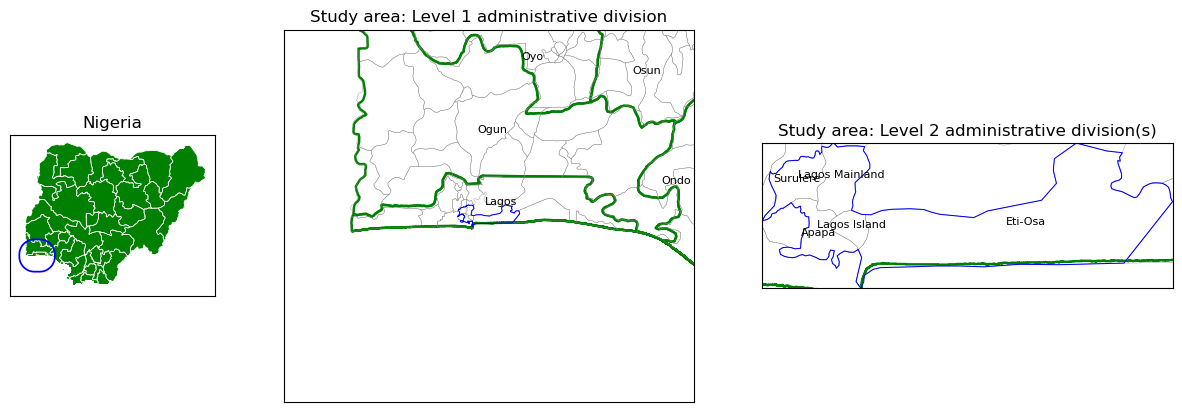

In [437]:
#######
# Visualize the administrative boundaries
########

fig, ax = plt.subplots(1, 3, width_ratios=[0.5, 1, 1], figsize=(15, 10), squeeze = True) 

# First panel contains country boundary with a blue boundary showing the perimeter with a buffer
COUNTRY_POLY.plot(ax=ax[0], color='green', linewidth=1)
COUNTRY_L1_POLY.boundary.plot(ax=ax[0], color='white', linewidth=0.5)
ENVELOPE_BUFFER = ENVELOPE.buffer(1)
ENVELOPE_BUFFER.boundary.plot(ax=ax[0], color='blue', linewidth=1.25)
ax[0].set_title(f'{COUNTRY}')
ax[0].set_xticks([])
ax[0].set_yticks([])

# Second panel contains COUNTRY_L1_POLY and COUNTRY_L2_POLY clipped to the ENVELOPE_BUFFER
COUNTRY_L1_POLY.boundary.plot(ax=ax[1], color='green', linewidth=1.75)
COUNTRY_L2_POLY.boundary.plot(ax=ax[1], color='grey', linewidth=0.25)
PERIM.boundary.plot(ax=ax[1], color='blue', linewidth=0.75)
# Clip COUNTRY_L1_POLY and COUNTRY_L2_POLY to the ENVELOPE_BUFFER
l1_clipped = gpd.clip(COUNTRY_L1_POLY, ENVELOPE_BUFFER.bounds.values[0].tolist())
# Add the names of the Level 1 Country administrative units, drop the administrative units not within the ENVELOPE_BUFFER
for idx, row in l1_clipped.iterrows():
    ax[1].text(row.geometry.centroid.x, row.geometry.centroid.y, row['NAME_1'], fontsize=8, ha='center')
# Set coordinate limits of the plot to the extent of the envelope buffer
ax[1].set_xlim(ENVELOPE_BUFFER.bounds.minx[0], ENVELOPE_BUFFER.bounds.maxx[0])
ax[1].set_ylim(ENVELOPE_BUFFER.bounds.miny[0], ENVELOPE_BUFFER.bounds.maxy[0])
ax[1].set_title(f'Study area: Level 1 administrative division')
ax[1].set_xticks([])
ax[1].set_yticks([])

# Third panel contains COUNTRY_L1_POLY and COUNTRY_L2_POLY clipped to the ADMIN boundary
COUNTRY_L1_POLY.boundary.plot(ax=ax[2], color='green', linewidth=1.75)
COUNTRY_L2_POLY.boundary.plot(ax=ax[2], color='grey', linewidth=0.25)
PERIM.boundary.plot(ax=ax[2], color='blue', linewidth=0.75)
#l2_clipped = gpd.clip(COUNTRY_L2_POLY, ENVELOPE.bounds.values[0].tolist())
for idx, row in ADMIN.iterrows():
    ax[2].text(row.geometry.centroid.x, row.geometry.centroid.y, row['NAME_2'], fontsize=8, ha='center')
# Set coordinate limits of the plot to the extent of the envelope buffer
ax[2].set_xlim(ENVELOPE.bounds.minx[0], ENVELOPE.bounds.maxx[0])
ax[2].set_ylim(ENVELOPE.bounds.miny[0], ENVELOPE.bounds.maxy[0])
ax[2].set_title(f'Study area: Level 2 administrative division(s)')
ax[2].set_xticks([])
ax[2].set_yticks([])

# Save file
plt.savefig(os.path.join(OUTPUTS_FOLDER, f'fig1_admin_boundaries.png'), dpi = 300, bbox_inches='tight', pad_inches=0.1)


Nigeria 
 State: Lagos 
 Local government area(s): ['Lagos Mainland', 'Lagos Island', 'Eti-Osa', 'Apapa', 'Surulere'] 
 Satellite imagery: Sentinel-2 mosaic from Sentienl Hub


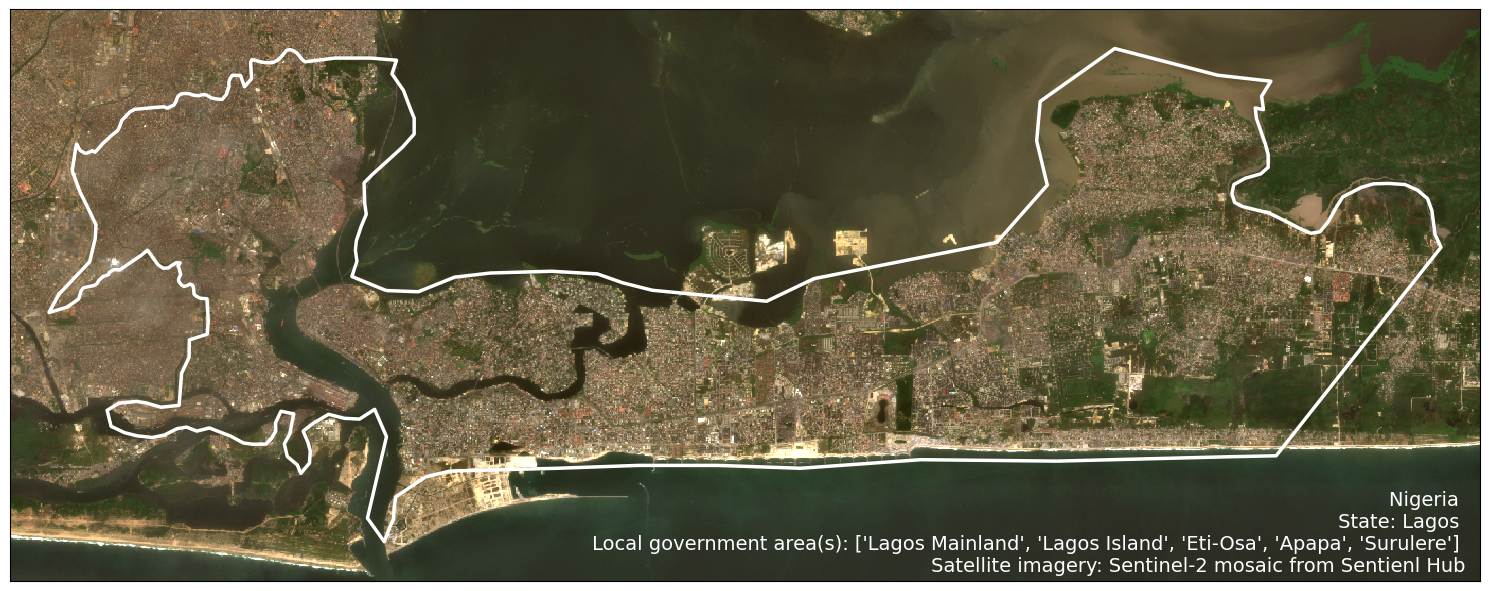

In [438]:
##################################
# STEP 2A: VISUALIZING STUDY AREA OVER SATELLITE IMAGERY
##################################

# Downloading previously sourced cloud-free Mosaic from Sentinel Hub
file = os.path.join(DOWNLOADS_FOLDER, "response_wbuffer.tiff")
imarray = rioxarray.open_rasterio(file)
imarray = imarray.transpose('y', 'x', 'band')

# Create a text string with the country, admin1 and admin2 names: 
annotation = f"{COUNTRY} \n {L1_UNIT}: {ADM_L1} \n {L2_UNIT}: {ADM_L2} \n Satellite imagery: Sentinel-2 mosaic from Sentienl Hub"
print(annotation)

boundaries = [PERIM]
edge_colors = ['white']
line_widths = [2.5]
face_colors = ['none']

file = os.path.join(OUTPUTS_FOLDER, "fig2_sampling_perimeter_ws2imagery.png")
plot_image_with_vectors(imarray, boundaries, edge_colors, face_colors, line_widths, filename = file,  factor=3.5 / 255, clip_range=(0, 1), addadminlabels=False, plotannotation = annotation)


In [439]:
##################################
# STEP 2A: GENERATE GRID OF BLOCKS
##################################

sampling_grid_gdf = generate_sampling_grid(BBOX, block_size = BLOCK_SIZE, boundary_gdf = PERIM)
TOTAL_BLOCKS_IN_GRID = sampling_grid_gdf.shape[0]

# Adding a unique ID to the sampling grid
sampling_grid_gdf.reset_index(drop=True, inplace=True)
sampling_grid_gdf['block_id'] = (sampling_grid_gdf.index + 1).astype(str)

# Split sampling_grid_gdf into N smaller dataframes each with 2000 blocks each
# This is to avoid running out of memory when processing the data
# The smaller dataframes are stored in a list
# The list is then iterated over to process the data in smaller chunks

# Print the number of blocks in the sampling grid
print("Number of blocks in the sampling grid: ", TOTAL_BLOCKS_IN_GRID)
print("Number of sub-grids to create: ", math.ceil(TOTAL_BLOCKS_IN_GRID/2000))
# Split the sampling grid into smaller dataframes
sampling_grids = [sampling_grid_gdf[i:i+2000] for i in range(0, sampling_grid_gdf.shape[0], 2000)]
    

East-west distance: 39.4025829562982 km North-South distance 13.960260326060528
East-west N blocks: 94 North-south N blocks: 263
Lon step (deg): 0.0013558104524713755 Lat step (deg): 0.0013356112765958385
Total area of boundary polygon: 266.09 km2
Total area of block polygons: 277.53 km2
Total number of blocks in sampling grid:  12371
Number of blocks in the sampling grid:  12371
Number of sub-grids to create:  7


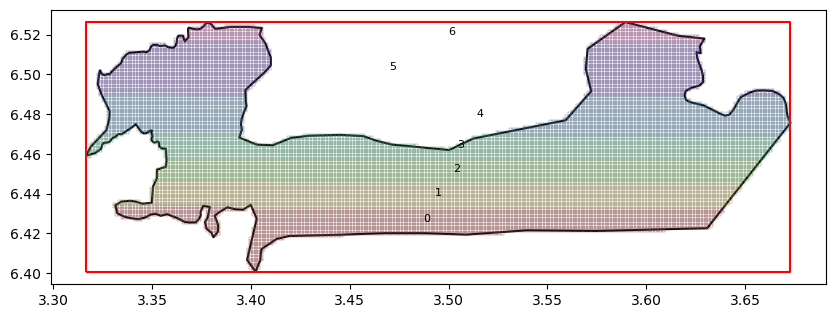

In [440]:

#############################################
# STEP 2B: VISUALIZE GRID OF BLOCKS and SECTIONS
###########################################

import colorsys
N = len(sampling_grids)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

fig, ax = plt.subplots(figsize=(10, 10))
# Administrative boundary
PERIM.boundary.plot(ax=ax, color="black")
# Enveolope of the bounding box
ENVELOPE.boundary.plot(ax=ax, color="red")
# Visualize all dataframes in sampling grids with different colors 
for i in range(len(sampling_grids)):
    sampling_grids[i].boundary.plot(ax=ax, color=RGB_tuples[i], linewidth=0.25)
# Label each index in sampling_grids on the plot at the average x, y coordiante of all blocks in the dataframe
for i in range(len(sampling_grids)):
    ax.text(sampling_grids[i].centroid.x.mean(), sampling_grids[i].centroid.y.mean(), i, fontsize=8, ha='center')
# Save figure
fig.savefig(os.path.join(OUTPUTS_FOLDER, f"fig4_initial_sampling_grid.png"), dpi=300, bbox_inches='tight')


In [449]:
####################################################################
# STEP 3A: RETRIEVE SATELLITE IMAGERY THAT COVERS THE AOI
###################################################################

# Sentinel-2 Surface Reflectance Harmonized data
srh_s2_image = get_cloudless_collection(BBOX, 'COPERNICUS/S2_SR_HARMONIZED', past_n_days = -120, cloudiness_threshold_pct=2.5, clip = True)
# Dynamic World (DW) Landcover
# FOr Nigeria past 500 days is used
dw_bands, dw_label = get_landcover_mosaic(BBOX, past_n_days = -500, clip = True)
dw_built = get_built_areas(dw_bands, threshold = 0.45)
# NASA Black Marble Nighttime Lights
viirs_composite = get_viirs_composite(BBOX, past_n_days = -120, clip = True)
# Retreiving open buildings dataset
opbuild = ee.FeatureCollection("GOOGLE/Research/open-buildings/v3/polygons").filterBounds(ee.Geometry.Rectangle(coords = BBOX))

Number of images in collection:  2


In [450]:
####################################################################
# STEP 3B: VISUALIZE VECTOR AND RASTER ASSETS
# THe interactive map is used to obtain Figures 3 and 5 in the methodology documents
###################################################################

m = geemap.Map()
m.centerObject(PERIM_EE, 12)

########################
# BOUNDING BOX
########################

# Add bounding box to the map
bbox_ee = ee.Geometry.Rectangle(BBOX)

m.add_layer(bbox_ee, {'color': 'ffffffff', "width": 2}, "Bounding Box")

#############################
# Display the cloudless mosaic
#############################

m.add_layer(
    srh_s2_image,
    {'min': 0,  'max': 2500, 'gamma': 1.1,
     'bands': ['B4', 'B3', 'B2']},
    'S2 cloud-free mosaic',
)

####
# Open buildings 
#####

m.add_layer(
    opbuild,
    {'color': 'ffffffff'},
    'Buildings',
)

#############################
# Display the nightime lights
#############################

viirs = viirs_composite.visualize(min=0, max= 100, palette = ['black', 'purple', 'cyan', 'green', 'yellow', 'red', 'white'])

m.add_layer(
    viirs, {}, 'VIIRS composite'
)

#############################
# Displayland cover
#############################

# Create a visualization that blends DW class label with probability.
# Define list pairs of DW LULC label and color.
CLASS_NAMES = [
    'water',
    'trees',
    'grass',
    'flooded_vegetation',
    'crops',
    'shrub_and_scrub',
    'built',
    'bare',
    'snow_and_ice',
]

VIS_PALETTE = [
    '419bdf',
    '397d49',
    '88b053',
    '7a87c6',
    'e49635',
    'dfc35a',
    'c4281b',
    'a59b8f',
    'b39fe1',
]

# Create an RGB image of the label (most likely class) on [0, 1].
dw_rgb = (
    dw_label
    .visualize(min=0, max=8, palette=VIS_PALETTE)
    .divide(255)
)

m.add_layer(
    dw_rgb,
    {'min': 0, 'max': 1},
    'Dynamic World V1 - land cover class',
)

########################
# BUILT AREAS (Greater than 50% probability)
########################

m.add_layer(
    dw_built,  
    {'color': 'ffffffff', "width": 2},
    'Built areas probabilistic'
    )

########################
# ADMIN BOUNDARY
########################

style = {
    'color': 'ffffffff', "width": 1.5, 'fillColor': 'ff475700'
}

m.add_layer(
    PERIM_EE.style(**style), 
    {},
    'Admin boundary'
    )

m


Map(center=[6.461714586329003, 3.498043547799162], controls=(WidgetControl(options=['position', 'transparent_b…

In [451]:
####################################################################
# STEP 4: Identifying blocks with high probability of built-up/urban infrastructure (using dynamic world LULC data)
####################################################################

# For each polyogn in the sampling grid, compute the percentage of pixels in the polygon 
# that have a value of 6 in the "label" band (i.e. the "built" class). This is the class with the highest estimated probabilty among all bands. 
# The result is a feature collection with the block ID, the percentage of high probability 'built' pixels in each polygon 
# that have a value of 6 in the "label" band and 1,0 column whether the polygon has greater than THRESHOLD% of pixels in the "built" class

BUILT_THRESHOLD = 0.75

# Select the "built" class from the label band, this creates a mask with values of 1 if the pixel is "built" an 0 otherwise
built_pixels = dw_label.select('label').eq(6)

# Create empty list to store the results
built_share_l = []

# For each section of the sampling grid, compute the percentage of built pixels in each block
for i in range(len(sampling_grids)):

    #subgrid = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in sampling_grids[i].iterrows()])
    subgrid = geemap.gdf_to_ee(sampling_grids[i])
    # Get fraction of built pixels per block in sampling grid
    built_share = built_pixels.reduceRegions(collection=subgrid.select(['block_id']), reducer=ee.Reducer.mean(), scale=10, tileScale=1)
  
    #built_blocks = built_blocks.filter(ee.Filter.gt('mean', BUILT_THRESHOLD))
    #Nbuilt = built_blocks.size().getInfo()
    #print(f"Section {i+1} of {len(sampling_grids)}: Number of built blocks: {Nbuilt}")
    #if (Nbuilt > 0): 
    #    built_blocks_l.append(built_blocks)

    built_share_l.append(built_share)

# Iterate over each element in built_blocks_l and convert it to a geodataframe using ee_to_gdf function: 
built_share_gdf = []
for i in range(len(built_share_l)):
    built_share_gdf.append(geemap.ee_to_gdf(built_share_l[i], columns = 'block_id'))

built_share_gdf = pd.concat(built_share_gdf) 

# Rename mean column
built_share_gdf.rename(columns={'mean': 'built_share'}, inplace=True)
# Create column with 1 if built_prob_mean is greater than BUILT_THRESHOLD
built_share_gdf['built'] = built_share_gdf['built_share'].apply(lambda x: 1 if x > BUILT_THRESHOLD else 0)

# Subsetting initial sampling grid to only include blocks with high share of likely built-up areas
built_blocks_gdf = built_share_gdf[built_share_gdf['built'] == 1]

#print(built_share_gdf.head())


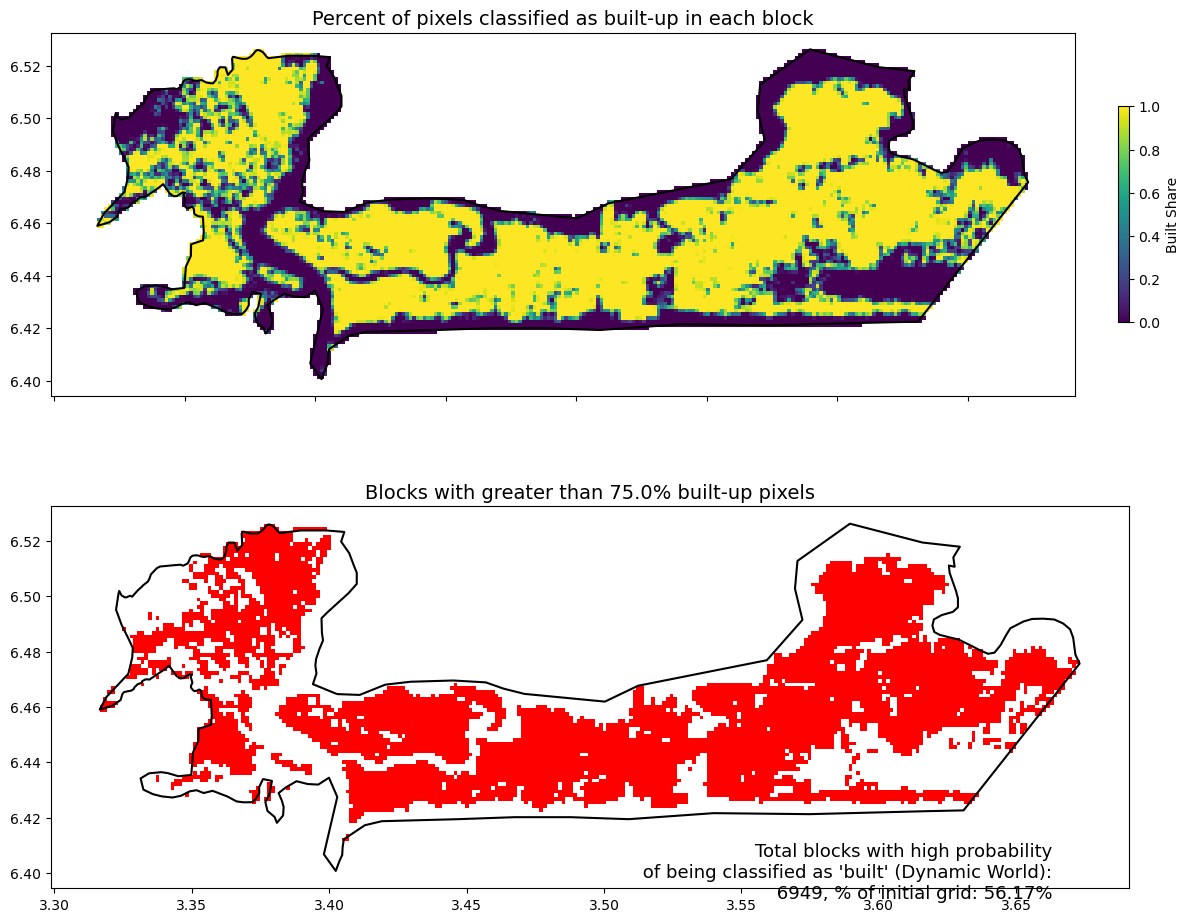

In [452]:
######################
# Visualizing distribution of percentage of built pixels by block in study area alongside blcoks with high probability of built-up/urban infrastructure
######################

# Print the total rows built_blocks_gdf:
label_builtup = f"Total blocks with high probability\n of being classified as 'built' (Dynamic World):\n {len(built_blocks_gdf)}, % of initial grid: {len(built_blocks_gdf)/TOTAL_BLOCKS_IN_GRID*100:.2f}%"

# Initialise the subplot function using number of rows and columns 
if (COUNTRY == "Nigeria"): 
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex = True, sharey = True) 
else: 
    fig, ax = plt.subplots(1, 2, figsize=(15, 35), sharex = True, sharey = True) 

# 2nd PLOT
PERIM.boundary.plot(ax = ax[0], color="black")
built_share_plot = built_share_gdf.plot(ax = ax[0], column='built_share', cmap='viridis', linewidth=0.25)
# Manually creating the legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=built_share_gdf['built_share'].min(), vmax=built_share_gdf['built_share'].max()))
sm._A = []  # Dummy array for the scalar mappable. matplotlib requires this property to not be None.
cbar = fig.colorbar(sm, ax=ax[0], fraction=0.01, pad=0.04)
cbar.set_label('Built Share')
# Add title
ax[0].set_title('Percent of pixels classified as built-up in each block', fontsize = 14)

# 2nd PLOT
PERIM.boundary.plot(ax = ax[1], color="black")
built_blocks_gdf.plot(ax = ax[1], color = "Red", linewidth=0.25)
# Add label1 to the plot at the bottom right of the plot
ax[1].text(PERIM.bounds.maxx - 0.01, PERIM.bounds.miny - 0.01, label_builtup, fontsize=13, ha='right')
# Add title
ax[1].set_title(f'Blocks with greater than {BUILT_THRESHOLD*100}% built-up pixels', fontsize = 14)

# reduce margins between subplots
plt.tight_layout()
plt.show()

# Save figure
fig.savefig(os.path.join(OUTPUTS_FOLDER, f"fig6A_dw_built_blocks.png"), dpi=300, bbox_inches='tight')


In [445]:
####################################################################
# STEP 4 (ALTERNATIVE): Identifying blocks with high probability of having buildings (using open buildings dataset)
####################################################################

if (COUNTRY in ["Nigeria"]):
    
    BUILDINGS_CONFIDENCE_THRESHOLD = 0.75

    # Create empty list to store the results
    building_counts_l = []

    # Select only buildings from opbuild that have a greater than threshold probability of being a building
    buildings = opbuild.filter(ee.Filter.gt('confidence', BUILDINGS_CONFIDENCE_THRESHOLD))

    # Create an intersection filter
    intersect_filter = ee.Filter.intersects(
        leftField='.geo',
        rightField='.geo',
        maxError=10
    )

    # Create a save-all join
    save_all_join = ee.Join.saveAll(
        matchesKey='buildings'
    )

    # Calculate total number of buildings within each feature.
    def count_buildings(feature):
        buildings_within = ee.List(feature.get('buildings'))
        total_buildings = ee.FeatureCollection(buildings_within).size()
        return feature.set('total_buildings', total_buildings)

    for i in range(len(sampling_grids)):

        #subgrid = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in sampling_grids[i].iterrows()])
        subgrid = geemap.gdf_to_ee(sampling_grids[i])

        # Apply the join
        joined = save_all_join.apply(subgrid, buildings, intersect_filter)
        building_counts = joined.map(count_buildings)
        building_counts_l.append(building_counts)

    # Iterate over each element in built_blocks_l and convert it to a geodataframe using ee_to_gdf function: 
    building_counts_gdf = []
    for i in range(len(building_counts_l)):
        building_counts_gdf.append(geemap.ee_to_gdf(building_counts_l[i]))

    building_counts_gdf = pd.concat(building_counts_gdf)   

    # Filter building_counts_gdf so that it only contains polygons with a total_buildings value greater than 0
    building_blocks_gdf = building_counts_gdf[building_counts_gdf['total_buildings'] > 0]

    # Print the minimum, maximum and average number of buildings in the blocks
    print("Minimum number of buildings per block in grid: ", building_counts_gdf['total_buildings'].min())
    print("Maximum number of buildings per block in grid: ", building_counts_gdf['total_buildings'].max())
    print("Mean number of buildings per block in grid: ", building_counts_gdf['total_buildings'].mean())


Minimum number of buildings per block in grid:  1
Maximum number of buildings per block in grid:  211
Mean number of buildings per block in grid:  30.960245636716223


Correlation between built_share and total_buildings: 0.46049941855484194


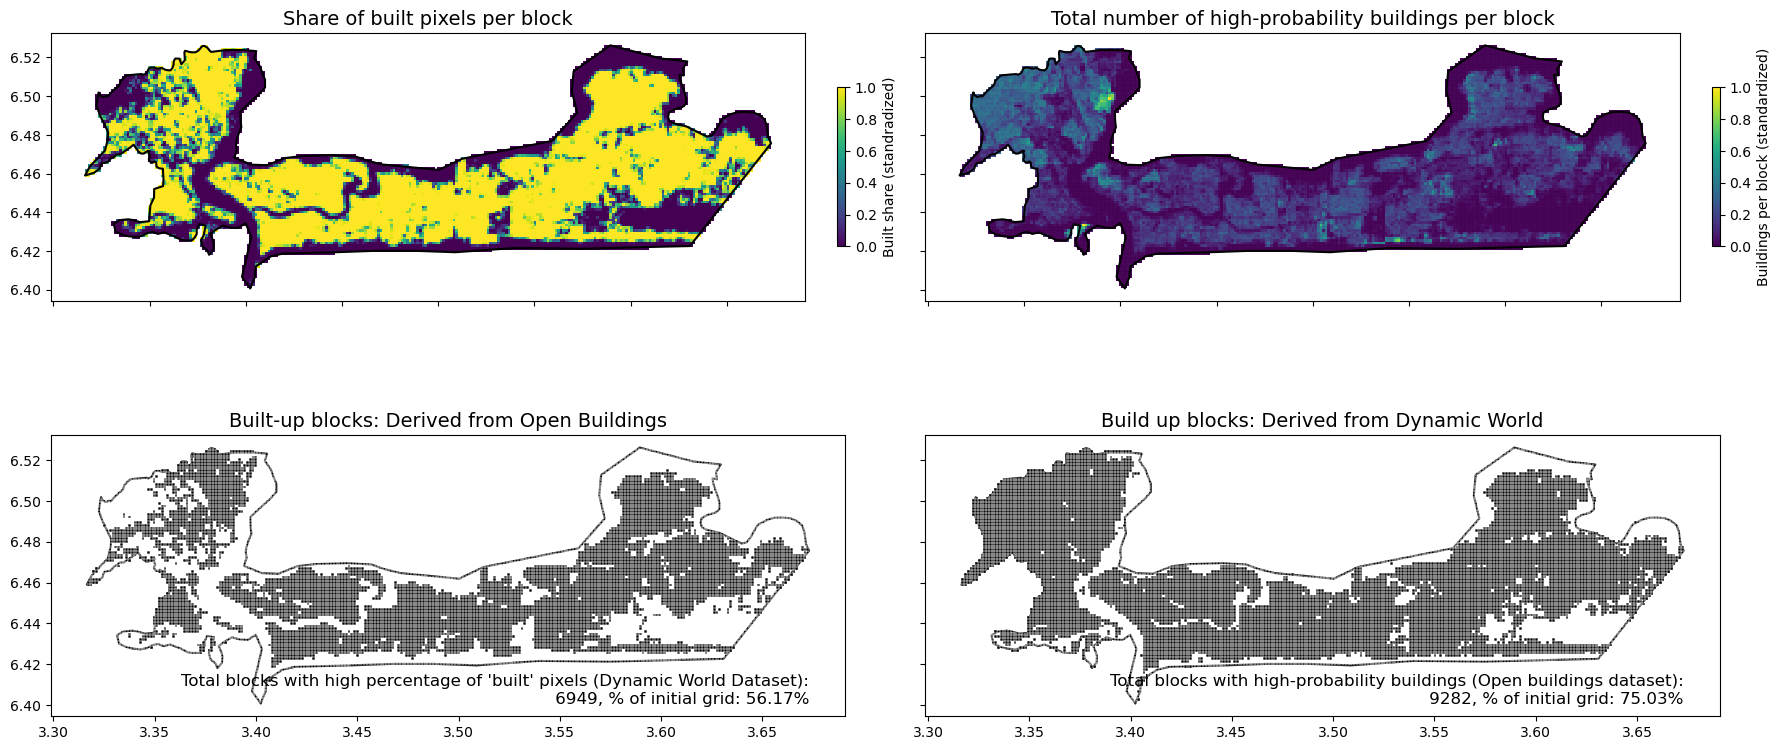

In [453]:
####################################################################
# STEP 4 (ALTERNATIVE): COMPARING DISTRIBUTION OF BUILT-UP AREAS AND BUILDINGS
####################################################################
if (COUNTRY in ["Nigeria"]):

    # Drop geometry colum from building)counts_gdf
    sampling_grid_wdata_gdf = built_share_gdf.merge(building_counts_gdf.drop(columns = ['geometry', 'id']), on = 'block_id', how = 'left')
    sampling_grid_wdata_gdf['total_buildings'].fillna(0, inplace=True)

    # Normalize the built_share column to be between 0 and 1
    sampling_grid_wdata_gdf['built_share_std'] = (sampling_grid_wdata_gdf['built_share'] - sampling_grid_wdata_gdf['built_share'].min()) / (sampling_grid_wdata_gdf['built_share'].max() - sampling_grid_wdata_gdf['built_share'].min())
    # Normalize the total_buildings column to be between 0 and 1
    sampling_grid_wdata_gdf['total_buildings_std'] = (sampling_grid_wdata_gdf['total_buildings'] - sampling_grid_wdata_gdf['total_buildings'].min()) / (sampling_grid_wdata_gdf['total_buildings'].max() - sampling_grid_wdata_gdf['total_buildings'].min())

    # Correlation between built_share and total_buildings
    correlation = sampling_grid_wdata_gdf['built_share'].corr(sampling_grid_wdata_gdf['total_buildings'])
    print(f"Correlation between built_share and total_buildings: {correlation}")


    # Print the total rows built_blocks_gdf:
    label_builtup = f"Total blocks with high percentage of 'built' pixels (Dynamic World Dataset):\n {len(built_blocks_gdf)}, % of initial grid: {len(built_blocks_gdf)/TOTAL_BLOCKS_IN_GRID*100:.2f}%"
    # Print the total rows in building_blocks_gdf:
    label_buildings = f"Total blocks with high-probability buildings (Open buildings dataset):\n {len(building_blocks_gdf)}, % of initial grid: {len(building_blocks_gdf)/TOTAL_BLOCKS_IN_GRID*100:.2f}%"

    # Initialise the subplot function using number of rows and columns 
    fig, ax = plt.subplots(2, 2, figsize=(18, 9), sharex = True, sharey = True) 

    # 1st PLOT
    PERIM.boundary.plot(ax = ax[0,0], color="black")

    sampling_grid_wdata_gdf.plot(ax = ax[0,0], column='built_share_std', legend = False, cmap='viridis', linewidth=0.25)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=sampling_grid_wdata_gdf['built_share'].min(), vmax=sampling_grid_wdata_gdf['built_share'].max()))
    sm._A = []  # Dummy array for the scalar mappable. matplotlib requires this property to not be None.
    cbar = fig.colorbar(sm, ax=ax[0,0], fraction=0.01, pad=0.04)
    cbar.set_label('Built share (standradized)')
    # Add title
    ax[0,0].set_title('Share of built pixels per block', fontsize = 14)

    # 2nd PLOT
    PERIM.boundary.plot(ax = ax[0,1], color="black")
    sampling_grid_gdf.boundary.plot(ax = ax[0,1], color = "white", linewidth = 0.01)

    sampling_grid_wdata_gdf.plot(ax = ax[0,1], column='total_buildings_std', legend=False, cmap='viridis', linewidth=0.25)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=sampling_grid_wdata_gdf['total_buildings_std'].min(), vmax=sampling_grid_wdata_gdf['total_buildings_std'].max()))
    sm._A = []  # Dummy array for the scalar mappable. matplotlib requires this property to not be None.
    cbar = fig.colorbar(sm, ax=ax[0,1], fraction=0.01, pad=0.04)
    cbar.set_label('Buildings per block (standardized)')
    # Add title
    ax[0,1].set_title('Total number of high-probability buildings per block', fontsize = 14)

    # 3rd PLOT
    PERIM.boundary.plot(ax = ax[1,0], color="black")

    built_blocks_gdf.plot(ax = ax[1,0], color = "black", linewidth=0.25)
    # Add label1 to the plot at the bottom right of the plot
    ax[1,0].text(PERIM.bounds.maxx, PERIM.bounds.miny, label_builtup, ha='right', fontsize = 12)
    sampling_grid_gdf.boundary.plot(ax = ax[1,0], color = "white", linewidth = 0.25)
    # Add title
    ax[1,0].set_title('Built-up blocks: Derived from Open Buildings', fontsize = 14)

    # 4th PLOT
    PERIM.boundary.plot(ax = ax[1,1], color="black")

    building_blocks_gdf.plot(ax = ax[1,1], color = "black", linewidth=0.25)
    # Add label1 to the plot at the bottom right of the plot
    ax[1,1].text(PERIM.bounds.maxx, PERIM.bounds.miny, label_buildings, ha='right', fontsize = 12)
    sampling_grid_gdf.boundary.plot(ax = ax[1,1], color = "white", linewidth = 0.25)
    # Add title
    ax[1,1].set_title('Build up blocks: Derived from Dynamic World', fontsize = 14)

    # reduce margins between subplots
    plt.tight_layout()
    plt.show()

    # Save figure
    fig.savefig(os.path.join(OUTPUTS_FOLDER, f"fig6B_sampling_grid_dw_v_opv3.png"), dpi=300, bbox_inches='tight')


In [454]:
##########################
### EXPORTING FINAL SAMPLING GRID AND SELECTING INITIAL SAMPLE OF BLOCKS
##########################

# Select whehter built_blocks_gdf or building_blocks_gdf will be used for the final sampling grid
if (COUNTRY == "Nigeria"):
    sampling_grid_final = building_blocks_gdf
else:
    sampling_grid_final = built_blocks_gdf


# Reset index of built_blocks_gdf
sampling_grid_final.reset_index(drop=True, inplace=True)
# Create a new column with a unique ID for each polygon that starts with the country_id 
# and is followed by the index of the polygon in the built_blocks_gdf dataframe
sampling_grid_final['block_id'] = (sampling_grid_final.index + 1).astype(str)

# Print the total unique polygons in built_blocks_gdf:
print("Total blocks in FINAL sampling grid: {}".format(len(sampling_grid_final['block_id'].unique())))
# PRint the total area of the unique polygons in built_blocks_gdf in km2: 
print("Total area of the FINAL sampling grid: {} km2".format(sampling_grid_final.to_crs('epsg:3395').area.sum() / 10**6))

# Randomly select N rows from the built_blocks_gdf dataframe
from numpy.random import RandomState
prng = RandomState(1234567890)
sampled_blocks = sampling_grid_final.sample(n = STAGE_1_SAMPLE_SIZE, random_state = prng)
# Print the IDs of the sampled blocks: 
print("IDs of sampled blocks: ", sampled_blocks['block_id'].unique())
# Add a new column in built_blocks_gdf that indicates whether a block is part of the initial sample 
# (i.e. whether it is in built_blocks_gdf_sample)
sampling_grid_final['in_sample'] = sampling_grid_final['block_id'].isin(sampled_blocks['block_id']).astype(int)

# Save the built_blocks_gdf and built_blocks_gdf_sample to a shapefile
sampling_grid_final.to_file(os.path.join(OUTPUTS_FOLDER, "final_sampling_grid.shp"))
sampled_blocks.to_file(os.path.join(OUTPUTS_FOLDER, "sampled_blocks_only.shp"))
# Save the built_blocks_gdf and built_blocks_gdf_sample to a .geojson file 
sampling_grid_final.to_file(os.path.join(OUTPUTS_FOLDER, "final_sampling_grid.geojson"), driver='GeoJSON')
sampled_blocks.to_file(os.path.join(OUTPUTS_FOLDER, "sampled_blocks_only.geojson"), driver='GeoJSON')


Total blocks in FINAL sampling grid: 9282
Total area of the FINAL sampling grid: 208.23382084636845 km2
IDs of sampled blocks:  ['7638' '7964' '7176' '5094' '2552' '8210' '7978' '3087' '1907' '3225'
 '3978' '9224' '305' '6654' '6662' '4057' '638' '4564' '7000' '5000'
 '1865' '5046' '603' '1885' '7802' '4559' '8575' '2031' '1677' '5057'
 '1050' '9171' '1994' '7530' '3813' '7188' '7273' '4738' '3974' '7654'
 '9044' '5747' '8746' '8269' '464' '8477' '1722' '1216' '4184' '1242'
 '2408' '4335' '6318' '6128' '1787' '4665' '2249' '7602' '4197' '7084'
 '6855' '7596' '5157' '2981' '3607' '890' '4871' '4265' '1818' '7072'
 '4718' '6067' '3077' '3815' '2213' '4713' '4172' '2716' '8404' '8749'
 '3465' '1077' '5726' '8106' '5814' '2587' '1781' '6533' '3478' '6010'
 '5024' '8608' '989' '7658' '1460' '5320' '6285' '5978' '7314' '789'
 '4836' '3403' '4366' '412' '3499' '3573' '7610' '3232' '1936' '7575'
 '7405' '3235' '4218' '2085' '1940' '2717' '2203' '5826' '1694' '3127'
 '2243' '580' '8436' '2851' 

Number of blocks in final sampling grid:  9282


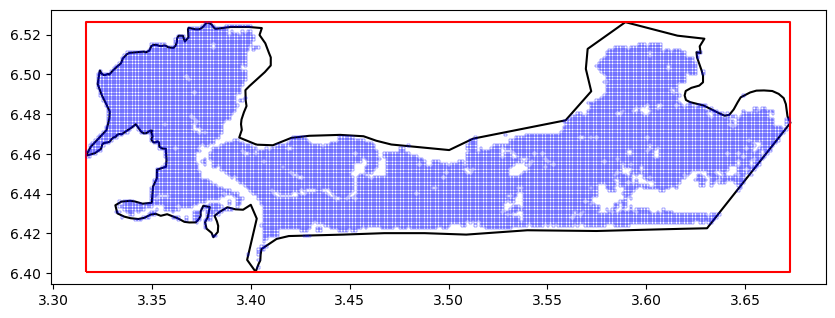

In [455]:
##########################
### SIMPLE VISUAL CHECK OF FINAL SAMPLING GIRD
##########################

# Visualize built blocks gdf
fig, ax = plt.subplots(figsize=(10, 10))
# Administrative boundary
PERIM.boundary.plot(ax=ax, color="black")
# Enveolope of the bounding box
ENVELOPE.boundary.plot(ax=ax, color="red")
sampling_grid_final.boundary.plot(ax=ax, color="blue", linewidth = 0.25)

# Print size of built_blocks_gdf
print("Number of blocks in final sampling grid: ", sampling_grid_final.shape[0])

Nigeria 
 State: Lagos 
 Local government area(s): ['Lagos Mainland', 'Lagos Island', 'Eti-Osa', 'Apapa', 'Surulere'] 
 Satellite imagery: Sentinel-2 mosaic from Sentienl Hub


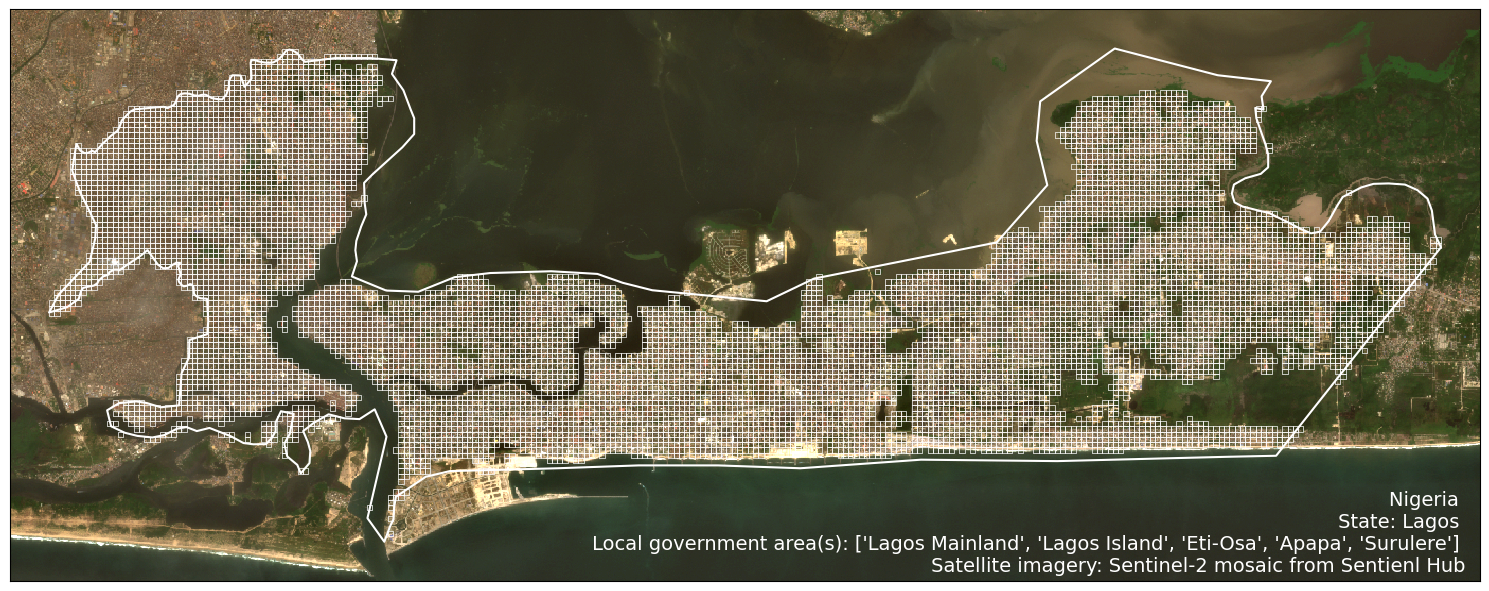

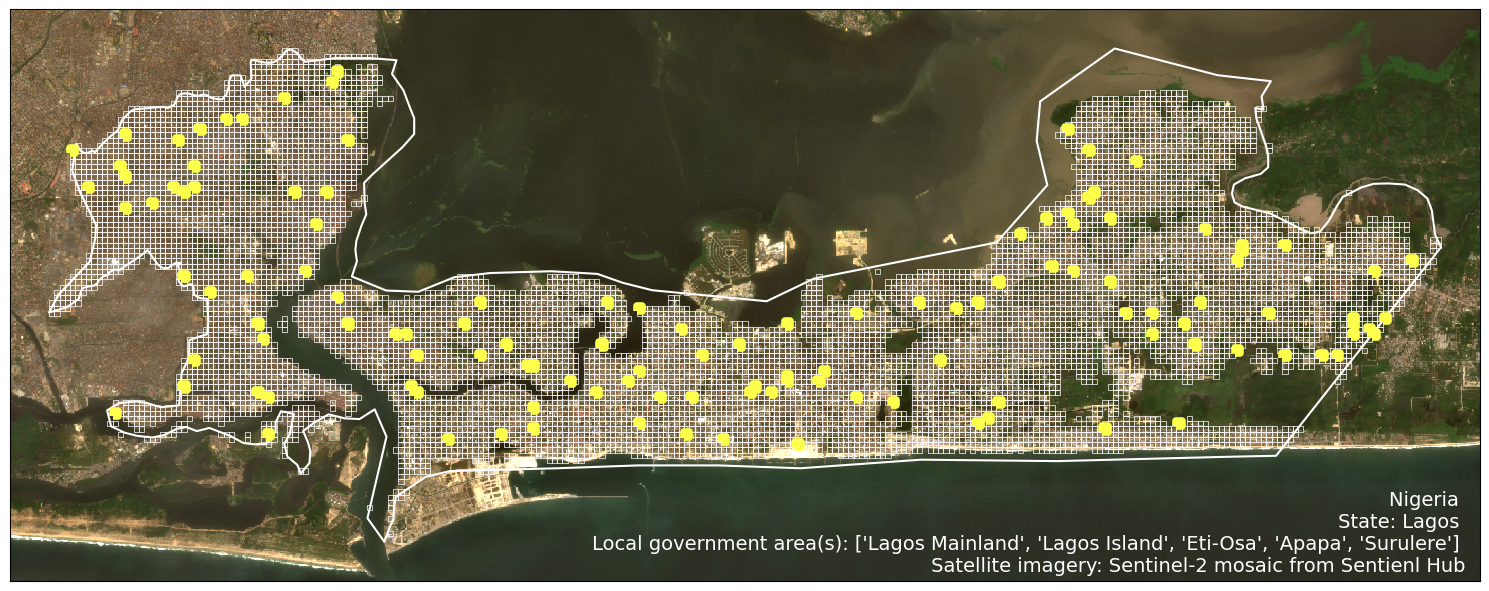

In [456]:
##########################
### VISUALIZING FINAL SAMPLING GRID OVER SATELLITE IMAGERY
##########################

# Create a text string with the country, admin1 and admin2 names: 
annotation = f"{COUNTRY} \n {L1_UNIT}: {ADM_L1} \n {L2_UNIT}: {ADM_L2} \n Satellite imagery: Sentinel-2 mosaic from Sentienl Hub"
print(annotation)

boundaries = [PERIM, sampling_grid_final]
edge_colors = ['white', 'white']
line_widths = [1.5, 0.5]
face_colors = ['none', 'none']

file = os.path.join(OUTPUTS_FOLDER, "fig7_sampling_grid_final.png")
plot_image_with_vectors(imarray, boundaries, edge_colors, face_colors, line_widths, filename = file,  factor=3.5 / 255, clip_range=(0, 1), addadminlabels=False, plotannotation = annotation)

boundaries = [PERIM, sampling_grid_final, sampled_blocks]
edge_colors = ['white', 'white', '#FCFF4B']
line_widths = [1.5, 0.5, 5.5]
face_colors = ['none', 'none', '#FCFF4B']

file = os.path.join(OUTPUTS_FOLDER, "fig8_initial_sampled_blocks.png")
plot_image_with_vectors(imarray, boundaries, edge_colors, face_colors, line_widths, filename = file,  factor=3.5 / 255, clip_range=(0, 1), addadminlabels=False, plotannotation = annotation)


In [457]:
# ##########################
# Visualizing sampled blocks
# This interactive map is used to obtain Figures 9A and 9B in the methodology document (as screenshots)
#############################

m = geemap.Map()
m.centerObject(PERIM_EE, 12)

#############################
# Display Sentinel-2 image.
#############################

m.add_layer(
    srh_s2_image,
    {'min': 0, 'max': 4000, 'bands': ['B4', 'B3', 'B2']},
    'Sentinel-2 L2',
    False
)

####
# Open buildings 
#####

m.add_layer(
    opbuild,
    {'color': 'ffffffff'},
    'Buildings',
    False
)

############################
# AOI boundary
############################

style = {
    'color': 'black', "width": 1.5, 'fillColor': 'ff475700'
}

m.add_layer(
    PERIM_EE.style(**style), 
    {},
    'Admin boundary'
    )

########################################
# Adding the built blocks (sampling frame)
#########################################

sampled_blocks_ee = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in sampled_blocks.iterrows()])

style = {
    'color': 'BD2D87', "width": 2.5, 'fillColor': 'ff475700'
}

m.add_layer(
    sampled_blocks_ee.style(**style), 
    {},
    'Sampled built blocks'
    )

m

Map(center=[6.461714586329003, 3.498043547799162], controls=(WidgetControl(options=['position', 'transparent_b…